In [41]:
import torch
import torch.utils.data as data
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import os
import pickle as pkl
import argparse
import pprint
from tqdm import tqdm

from models.stclassifier import PseTae_pretrained
from dataset import PixelSetData

In [42]:
torch.__version__


'1.12.1+cu116'

In [43]:
def prepare_model_and_loader(args):
    mean_std = pkl.load(open(args['dataset_folder'] + '/S2-2017-T31TFM-meanstd.pkl', 'rb'))
    extra = 'geomfeat' if args['geomfeat'] else None
    dt = PixelSetData(args['dataset_folder'], labels=args['label_class'], npixel=args['npixel'],
                      sub_classes=None,
                      norm=mean_std,
                      extra_feature=extra, return_id=True)
    dl = data.DataLoader(dt, batch_size=args['batch_size'], num_workers=args['num_workers'])

    model_config = dict(input_dim=args['input_dim'], mlp1=args['mlp1'], pooling=args['pooling'],
                        mlp2=args['mlp2'], n_head=args['n_head'], d_k=args['d_k'], mlp3=args['mlp3'],
                        dropout=args['dropout'], T=args['T'], len_max_seq=args['lms'],
                        positions=dt.date_positions if args['positions'] == 'bespoke' else None,
                        mlp4=args['mlp4'])

    if args['geomfeat']:
        model_config.update(with_extra=True, extra_size=4)
    else:
        model_config.update(with_extra=False, extra_size=None)

    model = PseTae_pretrained(args['weight_dir'], model_config, device=args['device'], fold=args['fold'])

    return model, dl


def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    else:
        return [recursive_todevice(c, device) for c in x]


def predict(model, loader, args):
    record = []
    device = torch.device(args['device'])

    for (x, y, ids) in tqdm(loader):
        y_true = (list(map(int, y)))
        ids = list(ids)

        x = recursive_todevice(x, device)
        with torch.no_grad():
            prediction = model(x)
        y_p = list(prediction.argmax(dim=1).cpu().numpy())

        record.append(np.stack([ids, y_true, y_p], axis=1))

    record = np.concatenate(record, axis=0)

    os.makedirs(args['output_dir'], exist_ok=True)
    np.save(os.path.join(args['output_dir'], 'Predictions_id_ytrue_y_pred.npy'), record)


def overall_performance(args):

    data =np.load(os.path.join(args['output_dir'], 'Predictions_id_ytrue_y_pred.npy'))
    data_num=data.shape[0]

    y_true=[]
    y_pred=[]
    for i in range(0, data_num):
        y_true1 = data[i][1]
        y_pred1 = data[i][2]
        y_true.append(y_true1)
        y_pred.append(y_pred1)
    y_true = [int(x) for x in y_true]
    y_pred = [int(x) for x in y_pred]

    conf_mat  = confusion_matrix(y_true, y_pred, labels=list(range(args['num_classes'])))
    pkl.dump(conf_mat, open(os.path.join(args['output_dir'], 'conf_mat.pkl'), 'wb'))

    cm = np.zeros((args['num_classes'], args['num_classes']))
    cm += pkl.load(open(os.path.join(args['output_dir'], 'conf_mat.pkl'), 'rb'))

    mat = cm
    TP = 0
    FP = 0
    FN = 0
    pre = 0

    per_class = {}
    for j in range(mat.shape[0]):
        d = {}
        tp = np.sum(mat[j, j])
        fp = np.sum(mat[:, j]) - tp
        fn = np.sum(mat[j, :]) - tp
        probR = (np.sum(mat[j, :]))/(np.sum(mat))
        probP = (np.sum(mat[:, j]))/(np.sum(mat))
        chance = probR * probP

        d['IoU'] = tp / (tp + fp + fn)
        d['Precision'] = tp / (tp + fp)
        d['Recall'] = tp / (tp + fn)
        d['F1-score'] = 2 * tp / (2 * tp + fp + fn)
        

        per_class[str(j)] = d

        TP += tp
        FP += fp
        FN += fn
        pre += chance

    pra = np.sum(np.diag(mat)) / np.sum(mat)

    overall = {}
    overall['micro_IoU'] = TP / (TP + FP + FN)
    overall['micro_Precision'] = TP / (TP + FP)
    overall['micro_Recall'] = TP / (TP + FN)
    overall['micro_F1-score'] = 2 * TP / (2 * TP + FP + FN)
    overall['micro_Kappa'] = (pra-pre)/(1-pre)

    macro = pd.DataFrame(per_class).transpose().mean()
    overall['MACRO_IoU'] = macro.loc['IoU']
    overall['MACRO_Precision'] = macro.loc['Precision']
    overall['MACRO_Recall'] = macro.loc['Recall']
    overall['MACRO_F1-score'] = macro.loc['F1-score']

    overall['Accuracy'] = np.sum(np.diag(mat)) / np.sum(mat)

    with open(os.path.join(args['output_dir'], 'overall.json'), 'w') as file:
        file.write(json.dumps(overall, indent=4))

    
    
    #labelss = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s']
    #disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels =labelss)
    disp = ConfusionMatrixDisplay(confusion_matrix=mat)

    fig, ax = plt.subplots(figsize=(21, 17))  # Set desired width and height
    disp.plot(ax=ax)
    # Customize additional plot elements as needed (e.g., fontsize, colormap)
    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust tick label fontsize
    plt.setp(disp.ax_.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(disp.ax_.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    save_path_cm = os.path.join(args['output_dir'], "confusion_matrix.png")
    plt.savefig(save_path_cm)
    #plt.show() 
    
def main(args):
    print('Preparation . . . ')
    model, loader = prepare_model_and_loader(args)
    print('Inference . . .')
    predict(model, loader, args)
    print('Results stored in directory {}'.format(args['output_dir']))
    overall_performance(args)


In [44]:
if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # /home/mhbokaei/shakouri/test/Satellite/dataset_folder100
    # /home/mhbokaei/shakouri/test/Satellite/dataset_folder10000
    # /home/mhbokaei/shakouri/test/Satellite/dataset_folder90000
    # /home/mhbokaei/shakouri/SatelliteImage_TimeSeries_Classification/dataset_folder
    # /home/mhbokaei/shakouri/test/Satellite/dataset_folder_test_zero
    # Set-up parameters
    


    parser.add_argument('--dataset_folder', default='/home/mhbokaei/shakouri/test/Satellite/Alldata/dataset_test_01_zero', type=str,
                        help='Path to the Test Folder.')
    parser.add_argument('--weight_dir', default='/home/mhbokaei/shakouri/test/Satellite/results', type=str,
                        help='Path to the folder containing the model weights')
    parser.add_argument('--fold', default='all', type=str,
                        help='Specify whether to load the weight sets of al folds (all) or '
                             'only load the weight of a specific fold by indicating its number')
    parser.add_argument('--output_dir', default='./output',
                        help='Path to the folder where the predictions should be stored')
    parser.add_argument('--num_workers', default=8, type=int, help='Number of data loading workers')
    parser.add_argument('--device', default='cuda', type=str,
                        help='Name of device to use for tensor computations (cuda/cpu)')
    parser.add_argument('--label_class', default='label_19class', type=str, help='it can be label_19class or label_44class')

    # Dataset parameters
    parser.add_argument('--batch_size', default=128, type=int, help='Batch size')
    parser.add_argument('--npixel', default=64, type=int, help='Number of pixels to sample from the input images')

    # Architecture Hyperparameters
    ## PSE
    parser.add_argument('--input_dim', default=10, type=int, help='Number of channels of input images')
    parser.add_argument('--mlp1', default='[10,32,64]', type=str, help='Number of neurons in the layers of MLP1')
    parser.add_argument('--pooling', default='mean_std', type=str, help='Pixel-embeddings pooling strategy')
    parser.add_argument('--mlp2', default='[132,128]', type=str, help='Number of neurons in the layers of MLP2')
    parser.add_argument('--geomfeat', default=1, type=int,
                        help='If 1 the precomputed geometrical features (f) are used in the PSE.')

    ## TAE
    parser.add_argument('--n_head', default=4, type=int, help='Number of attention heads')
    parser.add_argument('--d_k', default=32, type=int, help='Dimension of the key and query vectors')
    parser.add_argument('--mlp3', default='[512,128,128]', type=str, help='Number of neurons in the layers of MLP3')
    parser.add_argument('--T', default=1000, type=int, help='Maximum period for the positional encoding')
    parser.add_argument('--positions', default='bespoke', type=str,
                        help='Positions to use for the positional encoding (bespoke / order)')
    parser.add_argument('--lms', default=None, type=int,
                        help='Maximum sequence length for positional encoding (only necessary if positions == order)')
    parser.add_argument('--dropout', default=0.2, type=float, help='Dropout probability')

    ## Classifier
    parser.add_argument('--num_classes', default=19, type=int, help='Number of classes')
    parser.add_argument('--mlp4', default='[128, 64, 32, 19]', type=str, help='Number of neurons in the layers of MLP4')

{'T': 1000,
 'batch_size': 128,
 'd_k': 32,
 'dataset_folder': '/home/mhbokaei/shakouri/test/Satellite/Alldata/dataset_test_01_zero',
 'device': 'cuda',
 'dropout': 0.2,
 'fold': 'all',
 'geomfeat': 1,
 'input_dim': 10,
 'label_class': 'label_19class',
 'lms': None,
 'mlp1': [10, 32, 64],
 'mlp2': [132, 128],
 'mlp3': [512, 128, 128],
 'mlp4': [128, 64, 32, 19],
 'n_head': 4,
 'npixel': 64,
 'num_classes': 19,
 'num_workers': 8,
 'output_dir': './output',
 'pooling': 'mean_std',
 'positions': 'bespoke',
 'weight_dir': '/home/mhbokaei/shakouri/test/Satellite/results'}
Preparation . . . 
Loading pre-trained models . . .
Successfully loaded 10 model instances
Inference . . .


100%|██████████| 150/150 [00:07<00:00, 20.52it/s]
/tmp/ipykernel_895416/2652255274.py:91: RuntimeWarning: invalid value encountered in double_scalars
  d['IoU'] = tp / (tp + fp + fn)
/tmp/ipykernel_895416/2652255274.py:92: RuntimeWarning: invalid value encountered in double_scalars
  d['Precision'] = tp / (tp + fp)
/tmp/ipykernel_895416/2652255274.py:93: RuntimeWarning: invalid value encountered in double_scalars
  d['Recall'] = tp / (tp + fn)
/tmp/ipykernel_895416/2652255274.py:94: RuntimeWarning: invalid value encountered in double_scalars
  d['F1-score'] = 2 * tp / (2 * tp + fp + fn)


Results stored in directory ./output


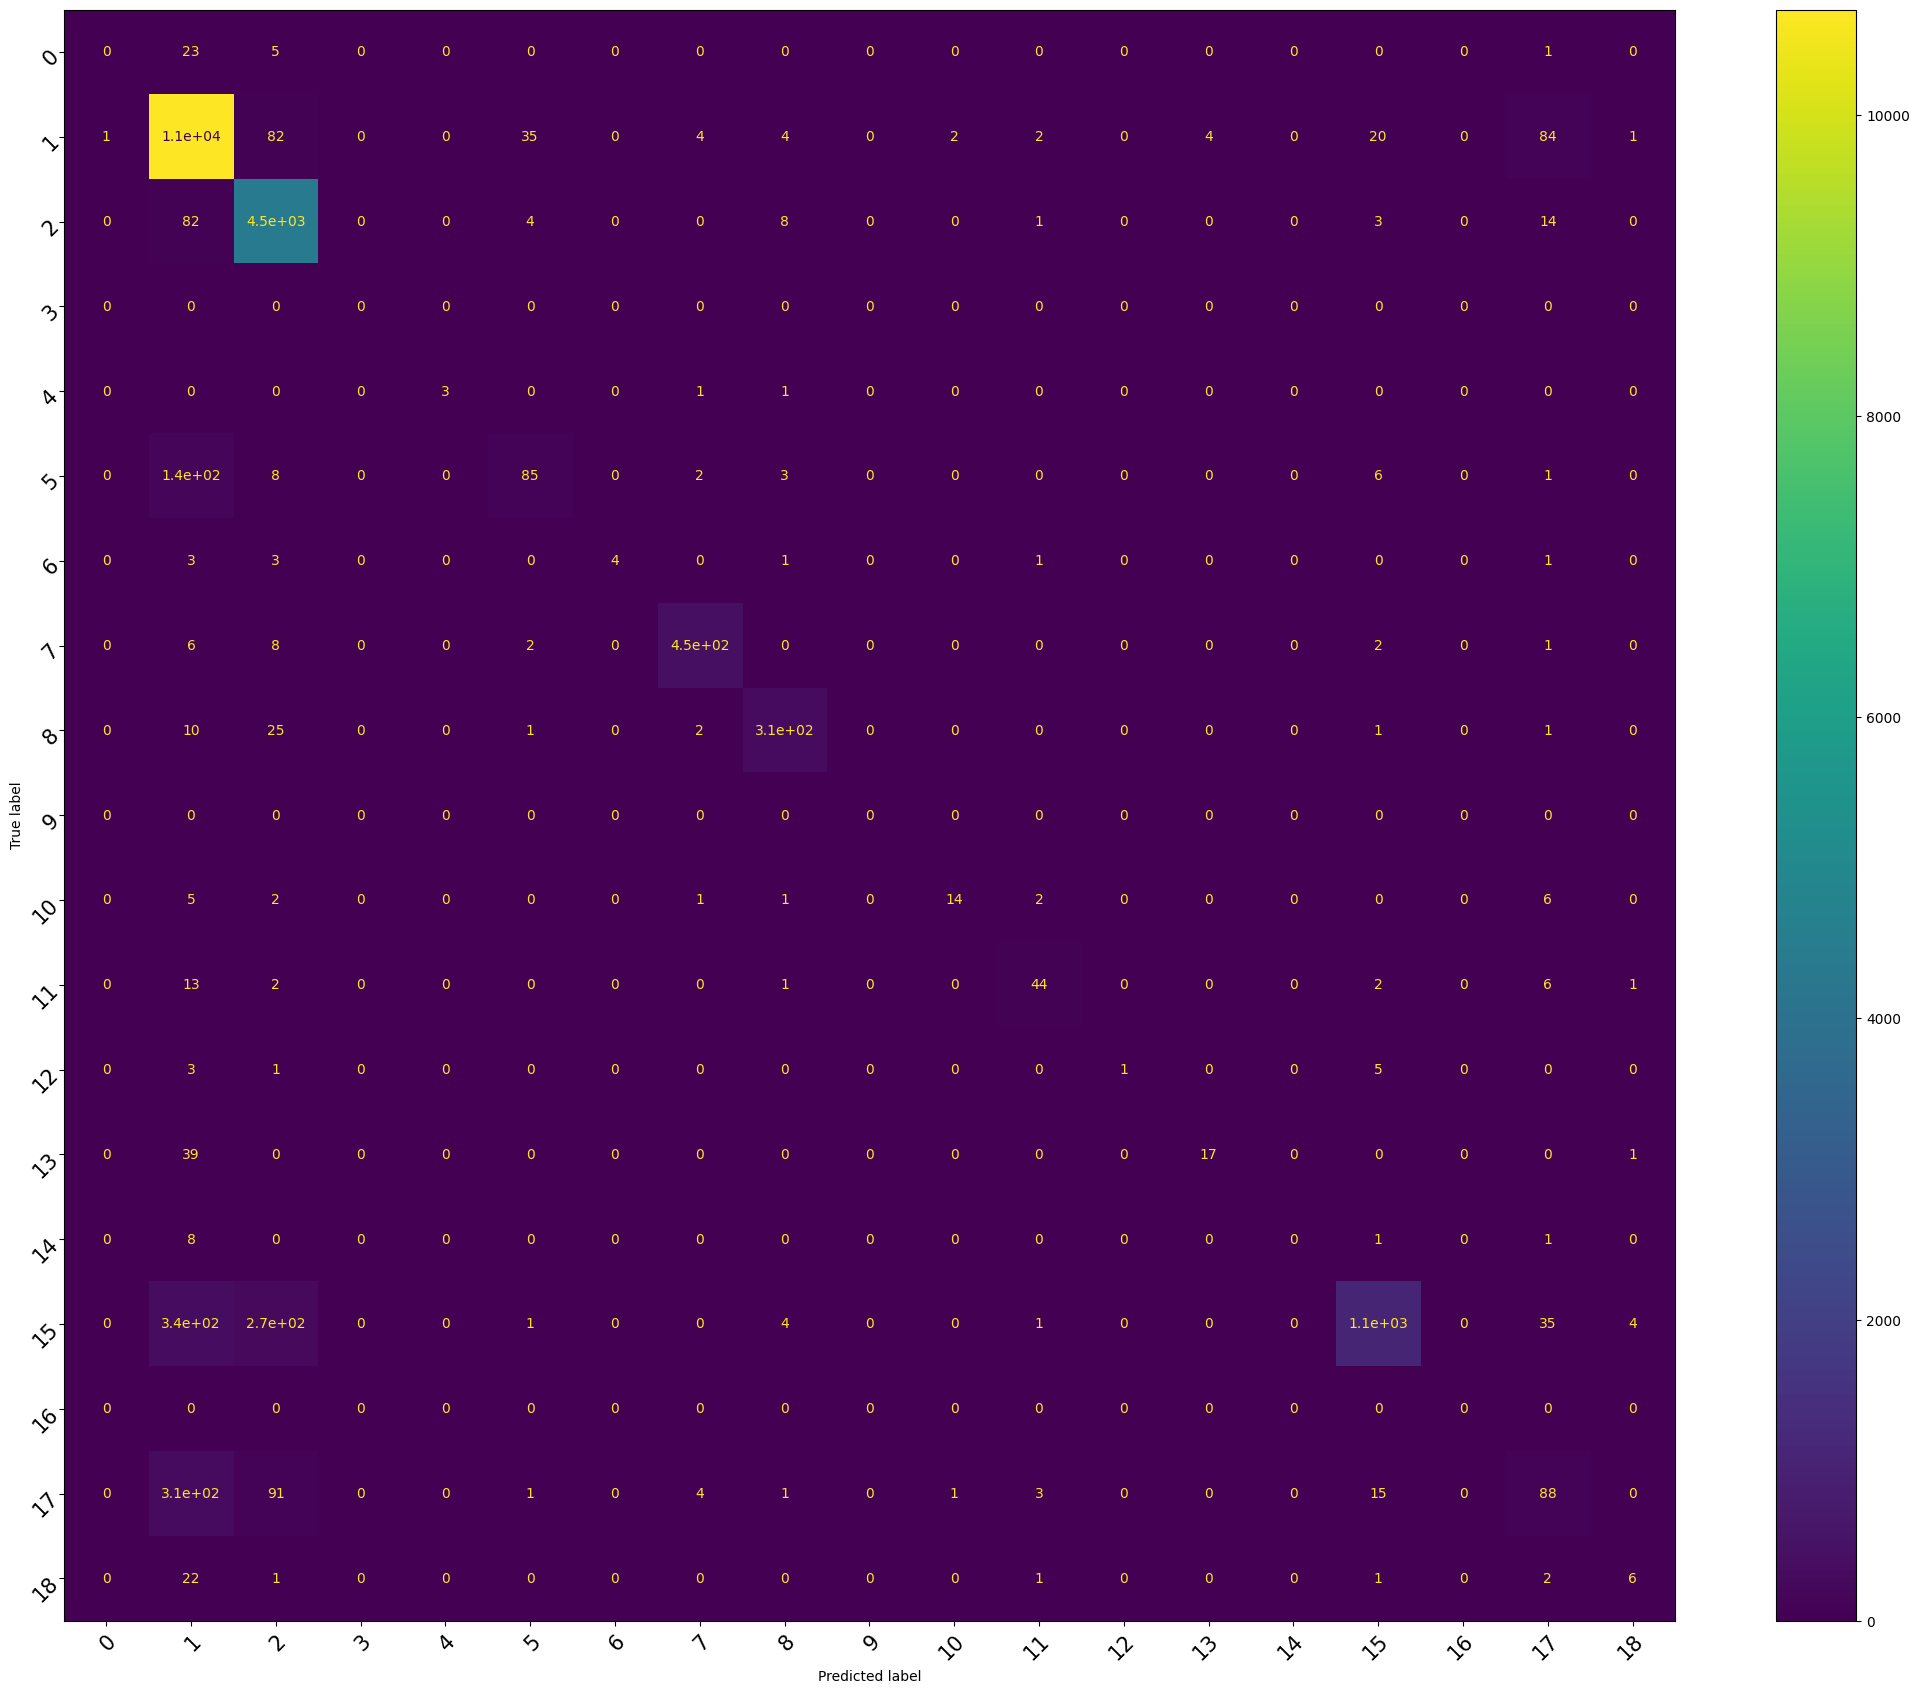

In [45]:
args= parser.parse_args(args=[])
args= vars(args)
for k, v in args.items():
        if 'mlp' in k:
            v = v.replace('[', '')
            v = v.replace(']', '')
            args[k] = list(map(int, v.split(',')))

pprint.pprint(args)
main(args)